### Stealth Attack with Corrupted Prompts

In [1]:
import sys

%cd ../../
%pwd

from tqdm import tqdm

# load utility functions
from util import utils
from util import evaluation

from stealth_edit import edit_utils

#### Paths and Parameters

In [2]:
models = ['gpt-j-6b', 'llama-3-8b', 'mamba-1.4b']
datasets = ['mcf', 'zsre']

results_path = './results/prompt/{}/{}/'
fs_path = './results/eval_fs/prompt/fs_prompt_{}_{}.pickle'
dims_path = './results/eval_dims/prompt/{}/{}/'

theta = 0.005

#### Load Evaluation

In [3]:
# load PPL metrics
perplexity_metrics = {}

for dataset_name in datasets:

    across_model_metrics = {}
    for model_name in models:
        across_model_metrics[model_name] = evaluation.eval_model_ppl(
            model_name,
            results_path = results_path.format(dataset_name, model_name),
            eval_op = True,
            eval_oap = False,
            eval_ap = False,
            eval_aug = True,
            eval_rnd = False,
            num_examples = 500
        )
    for model_name in models:
        across_model_metrics[model_name]['layer_indices'] = np.array([int(l.split('layer')[-1]) for l in across_model_metrics[model_name]['layer'][:,0]])

    summarise_metrics = {}
    for model_name in models:
        summarise_metrics[model_name] = evaluation.eval_model_ppl_metrics(
            across_model_metrics[model_name],
            eval_op = True,
            eval_oap = False,
            eval_ap = False,
            eval_aug = True,
            eval_rnd = False,
        )
    perplexity_metrics[dataset_name] = copy.deepcopy(summarise_metrics)


# load feature space metrics
mcf_fs_contents = {m: utils.loadpickle(fs_path.format('mcf', m)) for m in models}
zsre_fs_contents = {m: utils.loadpickle(fs_path.format('zsre', m)) for m in models}

100%|██████████| 7/7 [00:30<00:00,  4.32s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 8/8 [00:25<00:00,  3.19s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 7/7 [00:26<00:00,  3.83s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 8/8 [00:21<00:00,  2.75s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 12/12 [00:37<00:00,  3.09s/it]


#### Load Calculated Intrinsic Dimensions

In [4]:
dims_contents = {}
fpr_contents = {}

for dataset_name in datasets:

    model_dim_contents = {}
    model_fpr_contents = {}

    for model_name in models:
        dims_folder = dims_path.format(dataset_name, model_name)

        files_in_folder = os.listdir(dims_folder)
        model_dims = []
        model_fprs = []
        for i in range(len(files_in_folder)):
            contents = utils.loadpickle(os.path.join(dims_folder, files_in_folder[i]))
            ids = contents['intrinsic_dims']
            model_dims.append(np.sqrt(2**(-ids-1)))
            model_fprs.append(contents['fpr_ftd'])

        model_dims = np.array(model_dims)
        model_fprs = np.array(model_fprs)
        mean_dims, std_dims = utils.smart_mean_std(model_dims, axis=0)
        mean_fprs, std_fprs = utils.smart_mean_std(model_fprs, axis=0)
        model_dim_contents[model_name] = {
            'mean_dims': mean_dims,
            'std_dims': std_dims
        }
        model_fpr_contents[model_name] = {
            'mean_fprs': mean_fprs,
            'std_fprs': std_fprs
        }
    dims_contents[dataset_name] = copy.deepcopy(model_dim_contents)
    fpr_contents[dataset_name] = copy.deepcopy(model_fpr_contents)

#### Plot the Figure

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

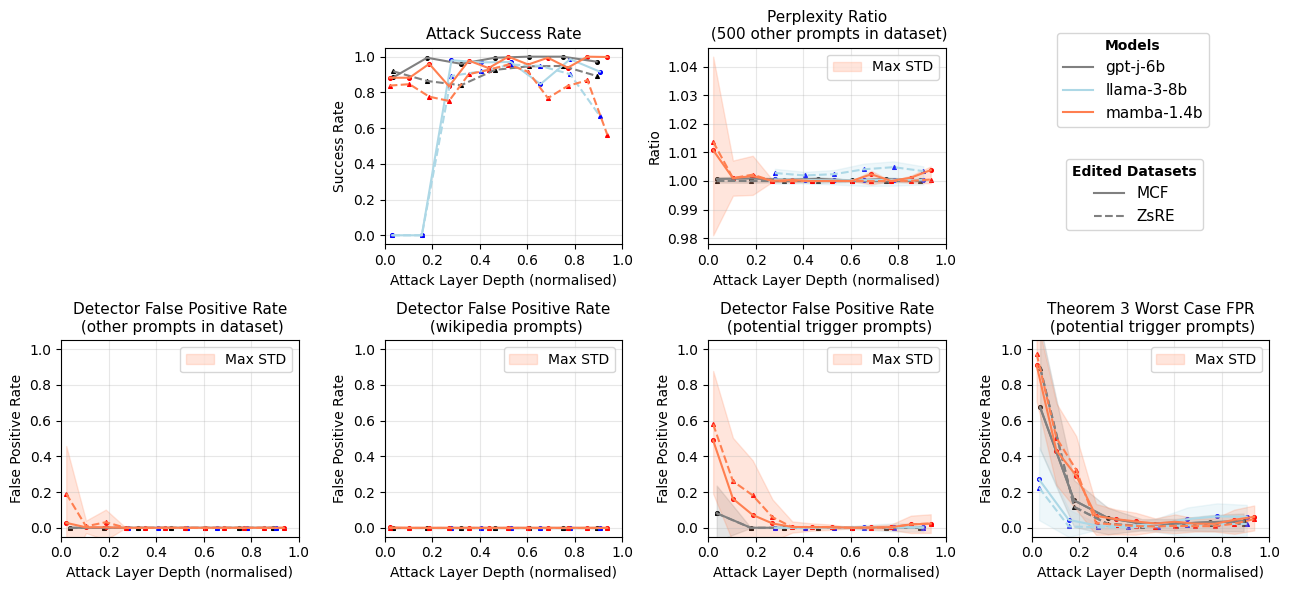

In [5]:
from util import evaluation
reload(evaluation)

fig, axs = plt.subplots(2, 4, figsize=(13, 6))

main_colors = ['black', 'b', 'red']
sub_colors = ['gray', 'lightblue', 'coral']

model_handles = []
dataset_handles = []

for i, model_name in enumerate(models):

    relative_depth = evaluation.model_layer_indices[model_name] \
        / evaluation.model_depth[model_name]

    axs[0,1].scatter(relative_depth, np.nan_to_num(perplexity_metrics['mcf'][model_name]['efficacy']), color=main_colors[i], s=7)
    md = axs[0,1].plot(relative_depth, np.nan_to_num(perplexity_metrics['mcf'][model_name]['efficacy']), color=sub_colors[i], label=model_name)
    model_handles.append(md[0])

    axs[0,1].scatter(relative_depth, np.nan_to_num(perplexity_metrics['zsre'][model_name]['efficacy']), color=main_colors[i], s=7, marker='^')
    axs[0,1].plot(relative_depth, np.nan_to_num(perplexity_metrics['zsre'][model_name]['efficacy']), color=sub_colors[i], linestyle='--')

    axs[0,1].set_xlabel('Attack Layer Depth (normalised)')
    axs[0,1].set_ylabel('Success Rate')
    axs[0,1].set_title('Attack Success Rate', fontsize=11)
    axs[0,1].set_xlim([0,1])

    if i == 2:
        label_to_insert = 'Max STD'
    else:
        label_to_insert = None

    mcf_mean = perplexity_metrics['mcf'][model_name]['ppl_other_mean']
    mcf_std = perplexity_metrics['mcf'][model_name]['ppl_other_std']
    zsre_mean = perplexity_metrics['zsre'][model_name]['ppl_other_mean']
    zsre_std = perplexity_metrics['zsre'][model_name]['ppl_other_std']

    max_mean = np.maximum(zsre_mean, mcf_mean)
    min_mean = np.minimum(zsre_mean, mcf_mean)
    max_std = np.maximum(zsre_std, mcf_std)


    axs[0,2].scatter(relative_depth, mcf_mean, color=main_colors[i], s=7)
    axs[0,2].plot(relative_depth, mcf_mean, color=sub_colors[i])

    axs[0,2].scatter(relative_depth, zsre_mean, color=main_colors[i], s=7, marker='^')
    axs[0,2].plot(relative_depth, zsre_mean, color=sub_colors[i], linestyle='--')
    axs[0,2].fill_between(relative_depth, (min_mean-max_std), (max_mean+max_std), color=sub_colors[i], alpha=0.2, label=label_to_insert)

    axs[0,2].set_ylabel('Ratio')
    axs[0,2].set_xlabel('Attack Layer Depth (normalised)')
    axs[0,2].set_title('Perplexity Ratio\n (500 other prompts in dataset)', fontsize=11)
    axs[0,2].set_xlim([0,1])
    axs[0,2].legend()

    mcf_mean_other_fprs = mcf_fs_contents[model_name]['mean_other_fprs']
    zsre_mean_other_fprs = zsre_fs_contents[model_name]['mean_other_fprs']
    mcf_std_other_fprs = mcf_fs_contents[model_name]['std_other_fprs']
    zsre_std_other_fprs = zsre_fs_contents[model_name]['std_other_fprs']

    max_mean_other_fprs = np.maximum(mcf_mean_other_fprs, zsre_mean_other_fprs)
    min_mean_other_fprs = np.minimum(mcf_mean_other_fprs, zsre_mean_other_fprs)
    max_std_other_fprs = np.maximum(mcf_std_other_fprs, zsre_std_other_fprs)

    axs[1,0].scatter(relative_depth, mcf_mean_other_fprs, color=main_colors[i], s=7)
    axs[1,0].plot(relative_depth, mcf_mean_other_fprs, color=sub_colors[i])

    axs[1,0].scatter(relative_depth, zsre_mean_other_fprs, color=main_colors[i], s=7, marker='^')
    axs[1,0].plot(relative_depth, zsre_mean_other_fprs, color=sub_colors[i], linestyle='--')
    axs[1,0].fill_between(relative_depth, (min_mean_other_fprs-max_std_other_fprs), (max_mean_other_fprs+max_std_other_fprs), color=sub_colors[i], alpha=0.2, label=label_to_insert)
    
    axs[1,0].set_xlabel('Attack Layer Depth (normalised)')
    axs[1,0].set_ylabel('False Positive Rate')
    axs[1,0].set_title('Detector False Positive Rate\n (other prompts in dataset)', fontsize=11)
    axs[1,0].set_xlim([0,1])
    axs[1,0].set_ylim([-0.05,1.05])
    axs[1,0].legend()

    mcf_mean_wiki_fprs = mcf_fs_contents[model_name]['mean_wiki_fprs']
    zsre_mean_wiki_fprs = zsre_fs_contents[model_name]['mean_wiki_fprs']
    mcf_std_wiki_fprs = mcf_fs_contents[model_name]['std_wiki_fprs']
    zsre_std_wiki_fprs = zsre_fs_contents[model_name]['std_wiki_fprs']

    max_mean_wiki_fprs = np.maximum(mcf_mean_wiki_fprs, zsre_mean_wiki_fprs)
    min_mean_wiki_fprs = np.minimum(mcf_mean_wiki_fprs, zsre_mean_wiki_fprs)
    max_std_wiki_fprs = np.maximum(mcf_std_wiki_fprs, zsre_std_wiki_fprs)

    axs[1,1].scatter(relative_depth, mcf_mean_wiki_fprs, color=main_colors[i], s=7)
    axs[1,1].plot(relative_depth, mcf_mean_wiki_fprs, color=sub_colors[i])

    axs[1,1].scatter(relative_depth, zsre_mean_wiki_fprs, color=main_colors[i], s=7, marker='^')
    axs[1,1].plot(relative_depth, zsre_mean_wiki_fprs, color=sub_colors[i], linestyle='--')
    axs[1,1].fill_between(relative_depth, (min_mean_wiki_fprs-max_std_wiki_fprs), (max_mean_wiki_fprs+max_std_wiki_fprs), color=sub_colors[i], alpha=0.2, label=label_to_insert)

    axs[1,1].set_xlabel('Attack Layer Depth (normalised)')
    axs[1,1].set_ylabel('False Positive Rate')
    axs[1,1].set_title('Detector False Positive Rate\n (wikipedia prompts)', fontsize=11)
    axs[1,1].set_xlim([0,1])
    axs[1,1].set_ylim([-0.05,1.05])
    axs[1,1].legend()

    mcf_mean_trig_fprs = fpr_contents['mcf'][model_name]['mean_fprs']
    zsre_mean_trig_fprs = fpr_contents['zsre'][model_name]['mean_fprs']
    mcf_std_trig_fprs = fpr_contents['mcf'][model_name]['std_fprs']
    zsre_std_trig_fprs = fpr_contents['zsre'][model_name]['std_fprs']

    max_mean_trig_fprs = np.maximum(mcf_mean_trig_fprs, zsre_mean_trig_fprs)
    min_mean_trig_fprs = np.minimum(mcf_mean_trig_fprs, zsre_mean_trig_fprs)
    max_std_trig_fprs = np.maximum(mcf_std_trig_fprs, zsre_std_trig_fprs)

    axs[1,2].scatter(relative_depth, mcf_mean_trig_fprs, color=main_colors[i], s=7)
    axs[1,2].plot(relative_depth, mcf_mean_trig_fprs, color=sub_colors[i])

    axs[1,2].scatter(relative_depth, zsre_mean_trig_fprs, color=main_colors[i], s=7, marker='^')
    axs[1,2].plot(relative_depth, zsre_mean_trig_fprs, color=sub_colors[i], linestyle='--')
    axs[1,2].fill_between(relative_depth, (min_mean_trig_fprs-max_std_trig_fprs), (max_mean_trig_fprs+max_std_trig_fprs), color=sub_colors[i], alpha=0.2, label=label_to_insert)

    axs[1,2].set_xlabel('Attack Layer Depth (normalised)')
    axs[1,2].set_ylabel('False Positive Rate')
    axs[1,2].set_title('Detector False Positive Rate\n (potential trigger prompts)', fontsize=11)
    axs[1,2].set_xlim([0,1])
    axs[1,2].set_ylim([-0.05,1.05])
    axs[1,2].legend()


    mcf_dim_mean = dims_contents['mcf'][model_name]['mean_dims']
    mcf_dim_std = dims_contents['mcf'][model_name]['std_dims']
    zsre_dim_mean = dims_contents['zsre'][model_name]['mean_dims']
    zsre_dim_std = dims_contents['zsre'][model_name]['std_dims']

    max_dim_mean = np.maximum(zsre_dim_mean, mcf_dim_mean)
    min_dim_mean = np.minimum(zsre_dim_mean, mcf_dim_mean)
    max_dim_std = np.maximum(zsre_dim_std, mcf_dim_std)

    axs[1,3].scatter(relative_depth, mcf_dim_mean, color=main_colors[i], s=7)
    axs[1,3].plot(relative_depth, mcf_dim_mean, color=sub_colors[i])

    axs[1,3].scatter(relative_depth, zsre_dim_mean, color=main_colors[i], s=7, marker='^')
    axs[1,3].plot(relative_depth, zsre_dim_mean, color=sub_colors[i], linestyle='--')
    std_hd = axs[1,3].fill_between(relative_depth, (min_dim_mean-max_dim_std), (max_dim_mean+max_dim_std), color=sub_colors[i], alpha=0.2, label=label_to_insert)

    axs[1,3].set_xlabel('Attack Layer Depth (normalised)')
    axs[1,3].set_ylabel('False Positive Rate')
    axs[1,3].set_title('Theorem 3 Worst Case FPR\n (potential trigger prompts)', fontsize=11)
    axs[1,3].set_xlim([0,1])
    axs[1,3].set_ylim([-0.05,1.05])
    axs[1,3].legend(handles=[std_hd], labels=['Max STD'])

    if i == 0:
        dh0 = axs[1,3].plot(relative_depth, mcf_dim_mean, color=sub_colors[i], label='MCF')
        dh1 = axs[1,3].plot(relative_depth, zsre_dim_mean, color=sub_colors[i], linestyle='--', label='ZsRE')
        dataset_handles.append(dh0[0])
        dataset_handles.append(dh1[0])

model_legend = fig.legend(model_handles, ['gpt-j-6b', 'llama-3-8b', 'mamba-1.4b'], bbox_to_anchor=(0.94, 0.95), loc = 'upper right', title='Models', title_fontproperties={'weight':'bold'}, fontsize=11)
dataset_legend = fig.legend(dataset_handles, ['MCF', 'ZsRE'], bbox_to_anchor=(0.935, 0.74), loc = 'upper right', title='Edited Datasets', title_fontproperties={'weight':'bold'}, fontsize=11)

axs[0,0].axis('off')
axs[0,3].axis('off')

for i in range(2):
    for j in range(4):
        axs[i,j].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('prompt.png', dpi=300)
plt.show()